# Weighted Similarity Network

## Goal
Build a **weighted user similarity network** from viewing behavior and analyze its properties.

## Network Definition
- **Nodes:** Users (N = 1,411)
- **Edges:** All user pairs connected with similarity as edge weight
- **Edge weights:** Cosine similarity of watch_ratio vectors (0 to 1)
- **Network type:** Undirected, weighted, fully connected

---

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Data and Create User-Video Matrix

We need a matrix where:
- Rows = users
- Columns = videos
- Values = watch_ratio (how much of each video the user watched)

This matrix captures each user's "viewing profile" across all videos.

In [2]:
# Load interaction data
print("Loading interaction data...")
interactions = pd.read_csv(r'..\data\raw\small_matrix.csv')

print(f"Total interactions: {len(interactions):,}")
print(f"Unique users: {interactions['user_id'].nunique():,}")
print(f"Unique videos: {interactions['video_id'].nunique():,}")

# Create user-video matrix
print("\nCreating user-video matrix...")
user_video_matrix = interactions.pivot_table(
    index='user_id',
    columns='video_id',
    values='watch_ratio',
    fill_value=0  # If user didn't watch, assume 0 (rare with 99.7% coverage)
)

print(f"Matrix shape: {user_video_matrix.shape[0]:,} users × {user_video_matrix.shape[1]:,} videos")
print(f"\nSample of user-video matrix:")
print(user_video_matrix.iloc[:5, :5])

Loading interaction data...
Total interactions: 4,676,570
Unique users: 1,411
Unique videos: 3,327

Creating user-video matrix...
Matrix shape: 1,411 users × 3,327 videos

Sample of user-video matrix:
video_id       103       109       120       122       128
user_id                                                   
14        0.429126  1.482039  0.728738  0.477810  0.439333
19        0.624466  1.070684  1.006064  0.759092  0.882691
21        1.415049  1.028840  1.809125  0.688823  0.588365
23        0.169223  2.549891  0.247487  0.438669  0.114338
24        0.345049  0.449337  0.802936  0.797411  1.875599


## 2. Compute User Similarity

**Cosine similarity** measures how similar two users' viewing patterns are:
- 1.0 = identical viewing behavior
- 0.0 = completely different

Formula: $\text{similarity}(u_i, u_j) = \frac{\vec{v}_i \cdot \vec{v}_j}{||\vec{v}_i|| \, ||\vec{v}_j||}$

where $\vec{v}_i$ is user i's watch_ratio vector across all videos.

Computing pairwise user similarity...
(This may take a minute for 1,411 users)

Similarity matrix shape: (1411, 1411)
  (1,411 users × 1,411 users)

Similarity statistics (all 1,989,510 user pairs):
  Mean:   0.5710
  Median: 0.5750
  Std:    0.2036
  Min:    0.0228
  Max:    0.9935


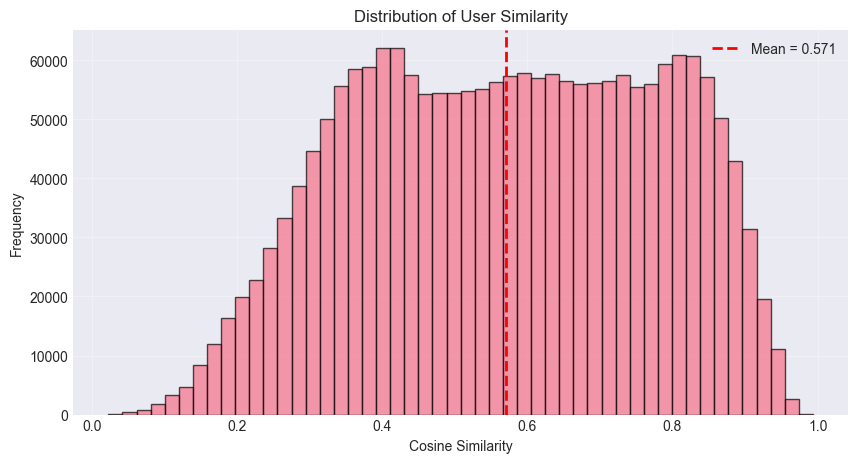

In [3]:
# Compute pairwise cosine similarity between all users
print("Computing pairwise user similarity...")
print("(This may take a minute for 1,411 users)\n")

similarity_matrix = cosine_similarity(user_video_matrix.values)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"  ({similarity_matrix.shape[0]:,} users × {similarity_matrix.shape[1]:,} users)")

# Convert to DataFrame for easier handling
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=user_video_matrix.index,
    columns=user_video_matrix.index
)

# Set diagonal to NaN (user's similarity with themselves = 1.0, not interesting)
np.fill_diagonal(similarity_matrix, np.nan)

# Analyze similarity distribution
similarities = similarity_matrix[~np.isnan(similarity_matrix)]

print(f"\nSimilarity statistics (all {len(similarities):,} user pairs):")
print(f"  Mean:   {np.mean(similarities):.4f}")
print(f"  Median: {np.median(similarities):.4f}")
print(f"  Std:    {np.std(similarities):.4f}")
print(f"  Min:    {np.min(similarities):.4f}")
print(f"  Max:    {np.max(similarities):.4f}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(similarities, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of User Similarity')
plt.axvline(np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(similarities):.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 3. Build Weighted Similarity Network

Create fully connected graph with all edges weighted by cosine similarity.

In [4]:
print("Building weighted similarity network...")
print("="*70)

# Create graph
G = nx.Graph()

# Add all users as nodes
users = user_video_matrix.index.tolist()
G.add_nodes_from(users)
print(f"Added {G.number_of_nodes():,} nodes")

# Add all edges with similarity as weight
edges_added = 0
for i, user_i in enumerate(users):
    for j, user_j in enumerate(users[i+1:], start=i+1):  # Only upper triangle (undirected)
        sim = similarity_df.loc[user_i, user_j]
        G.add_edge(user_i, user_j, weight=sim)
        edges_added += 1

print(f"Added {edges_added:,} edges")

# Network statistics
N = G.number_of_nodes()
E = G.number_of_edges()
max_edges = N * (N - 1) / 2
density = nx.density(G)

print(f"\nNetwork Properties:")
print(f"  Nodes (N):        {N:,}")
print(f"  Edges (E):        {E:,}")
print(f"  Density:          {density:.4f} ({100*density:.2f}%)")
print(f"  Max possible edges: {int(max_edges):,}")
print(f"  Is connected:     {nx.is_connected(G)}")

if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    largest_cc = max(components, key=len)
    print(f"  Components:       {len(components)}")
    print(f"  Largest component: {len(largest_cc)} nodes ({100*len(largest_cc)/N:.1f}%)")
    print(f"\n  → Working with largest connected component for path-based metrics")
    G_main = G.subgraph(largest_cc).copy()
else:
    G_main = G

Building weighted similarity network...
Added 1,411 nodes
Added 994,755 edges

Network Properties:
  Nodes (N):        1,411
  Edges (E):        994,755
  Density:          1.0000 (100.00%)
  Max possible edges: 994,755
  Is connected:     True


In [ ]:
# Compute strengths (weighted degree)
strength = dict(G.degree(weight='weight'))
strength_values = list(strength.values())

print("Strength Statistics:")
print("="*70)
print(f"  Mean strength ⟨s⟩:  {np.mean(strength_values):.2f}")
print(f"  Median strength:    {np.median(strength_values):.2f}")
print(f"  Max strength:       {np.max(strength_values):.2f}")
print(f"  Min strength:       {np.min(strength_values):.2f}")
print(f"  Std deviation:      {np.std(strength_values):.2f}")

# Strength distribution plot
plt.figure(figsize=(10, 5))
plt.hist(strength_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Strength s')
plt.ylabel('Frequency')
plt.title('Strength Distribution')
plt.axvline(np.mean(strength_values), color='red', linestyle='--', 
            linewidth=2, label=f'Mean ⟨s⟩ = {np.mean(strength_values):.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 5. Summary

In [ ]:
print("="*70)
print("WEIGHTED SIMILARITY NETWORK SUMMARY")
print("="*70)

print(f"
Network Properties:")
print(f"  Nodes (N):          {G.number_of_nodes():,}")
print(f"  Edges (E):          {G.number_of_edges():,}")
print(f"  Density:            {nx.density(G):.4f} (fully connected)")
print(f"  Mean edge weight:   {np.mean([d['weight'] for u, v, d in G.edges(data=True)]):.4f}")

print(f"
Node Properties:")
print(f"  All degrees:        {degree_values[0]} (N-1)")
print(f"  Mean strength:      {np.mean(strength_values):.2f}")
print(f"  Std strength:       {np.std(strength_values):.2f}")

print(f"
Key Insight:")
print(f"  • Fully connected weighted network")
print(f"  • Degree is uniform → use strength for influence")
print(f"  • Edge weights = similarity (0-1)")
print(f"  • For SI spreading: transmission = β × similarity")

print("
" + "="*70)
print("Ready for SI spreading analysis!")
print("="*70)